# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras as ks
from sklearn.metrics import confusion_matrix
import os
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

# Load the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download the `prediction_head_centered.zip ` from Google Drive (https://drive.google.com/drive/folders/1xzN19rTxewEiwzeBN3g88w5UBN2Z0Z0S?usp=share_link) and had it to your Drive or local directory if you are not using Google Colab.

Next step is to unzip the file.

In [ ]:
! unzip 'prediction_head_centered.zip'

# Utility Functions
To perform the analysis of the model we need some utily functions.

## Create the Dataset
The following functions are needed for creating the numpy dataset. There is a short explanation to all of them after each declaration.

In the code these functions are located in `utils.sequence_handling`

In [5]:
def divide_sequence(sequence, length):
    """
    From a sequence (joints_axis, frames) the function reduces the frame-length to
    sequences of shape (joints_axis, length) and store them in a new np.array that
    the function returns
    :param sequence: numpy sequence
    :param length: size of the window
    :return: np.array containing all subsequences obtained from sequence
    """
    if length == 3480:
        return np.array(sequence)
    _, dim = sequence.shape
    tmp = []
    for i in range(dim - length):
        tmp_seq = sequence[:, i:i + length]
        tmp.append(tmp_seq)
    return np.array(tmp)


def normalize(x):
    """
    Normalize values in a sequence x considering its last axis
    :param x: sequence
    :return: normalized sequence
    """
    return tf.keras.utils.normalize(x, axis=-1)


def create_dataset(first_stimulus_path, second_stimulus_path, third_stimulus_path=None, length=3480):
    """
    Create numpy dataset
    :param first_stimulus_path: path to the numpy directory containing the npy sequences for the first stimulus
    :param second_stimulus_path: path to the numpy directory containing the npy sequences for the second stimulus
    :param third_stimulus_path: path to the numpy directory containing the npy third for the first stimulus (if None it will not be considered, i.e., binary case)
    :param length: length of the (sub)sequences, in our case we use as default the total length (3480)
    :return: a tuple in the form (data, labels)
    """
    if length < 3480:
        data = None
    else:
        data = []
    labels = []
    tmp_list = [c for c in os.listdir(first_stimulus_path) if c.endswith('.npy')]
    for i in tmp_list:
        tmp_npy = np.load(os.path.join(first_stimulus_path, i))
        labels.append(0)
        if type(data) is list:
            data.append(tmp_npy)
        else:
            if data is None:
                data = divide_sequence(tmp_npy, length)
            else:
                data = np.r_[data, divide_sequence(tmp_npy, length)]

    tmp_list = [c for c in os.listdir(second_stimulus_path) if c.endswith('.npy')]
    for i in tmp_list:
        tmp_npy = np.load(os.path.join(second_stimulus_path, i))
        labels.append(1)
        if type(data) is list:
            data.append(tmp_npy)
        else:
            data = np.r_[data, divide_sequence(tmp_npy, length)]

    if third_stimulus_path is not None:
        tmp_list = [c for c in os.listdir(third_stimulus_path) if c.endswith('.npy')]
        for i in tmp_list:
            tmp_npy = np.load(os.path.join(third_stimulus_path, i))
            labels.append(2)
            if type(data) is list:
                data.append(tmp_npy)
            else:
                data = np.r_[data, divide_sequence(tmp_npy, length)]

    if type(data) is list:
        return normalize(np.array(data)), np.array(labels)
    else:
        return normalize(data), np.array(labels)

## Evaluate the model
For evaluating the model we can plot the confusion matrix with the following function. In the code the function is located in `utils.visualize`

In [13]:
def conf_matrix(model_path, stim1_dir_path, stim2_dir_path, stim3_dir_path=None, ranges=['control', 'sugar'],
                save_png=True, path_png='plot.png'):
    """
    Generate the confusion matrix
    :param model_path: path to the model
    :param stim1_dir_path: path to the directory containing the npy related to the first stimulus
    :param stim2_dir_path: path to the directory containing the npy related to the second stimulus
    :param stim3_dir_path: path to the directory containing the npy related to the third stimulus (can be None)
    :param ranges: list of strings indicating the classes
    :param save_png: boolean, True to save the confusion matrix into a png
    :param path_png: if save_png is True the confusion matrix image is saved using this path
    :return:
    """
    data, labels = create_dataset(
        stim1_dir_path,
        stim2_dir_path,
        stim3_dir_path if stim3_dir_path is None else stim3_dir_path
    )

    model = ks.models.load_model(model_path)
    preds = model.predict(data, verbose=False)
    if stim3_dir_path is None:
        preds = [1 if pred > 0.5 else 0 for pred in preds]
    else:
        preds = np.argmax(preds, axis=-1)
    cf = confusion_matrix(labels, preds)
    df_cm = pd.DataFrame(cf, ranges, ranges)
    sn.set(font_scale=1.4)
    fig = sn.heatmap(df_cm, annot=True, annot_kws={'size': 16}).get_figure()
    if save_png:
        fig.savefig(path_png)

The following function performs the `model.evaluate `for all the sets printing the results.

In [7]:
def evaluate(train_set, train_labels, val_set, val_labels, test_set, test_labels, model_name):
    model = tf.keras.models.load_model(model_name)
    train_loss, train_accuracy = model.evaluate(train_set, train_labels, verbose=False)
    val_loss, val_accuracy = model.evaluate(val_set, val_labels, verbose=False)
    test_loss, test_accuracy = model.evaluate(test_set, test_labels, verbose=False)
    print(f'{model_name}:\n\tTrain loss: {train_loss}\n\tTrain accuracy: {train_accuracy}\n\tVal loss: {val_loss}\n\tVal accuracy: {val_accuracy}\n\tTest loss: {test_loss}\n\tTest accuracy: {test_accuracy}')

# Test Classification
Change the following variables in order to match you path for prediction_head_centered and the path related to the model. Remember that if you are using a binary classification model (e.g., control-sugar) it is important to change also the `n_classes` variable along with the `classes` list.

In [8]:
path = 'prediction_head_centered'
model_path = 'best3classes.keras'
n_classes = 3
classes = ['control', 'sugar', 'ammonia']

Let's create the numpy sets

In [10]:
train_set, train_labels = create_dataset(
    os.path.join(path, classes[0] + '/train/'),
    os.path.join(path, classes[1] + '/train/'),
    os.path.join(path, classes[2] + '/train/') if n_classes == 3 else None
)
val_set, val_labels = create_dataset(
    os.path.join(path, classes[0] + '/val/'),
    os.path.join(path, classes[1] + '/val/'),
    os.path.join(path, classes[2] + '/val/') if n_classes == 3 else None
)
test_set, test_labels = create_dataset(
    os.path.join(path, classes[0] + '/test/'),
    os.path.join(path, classes[1] + '/test/'),
    os.path.join(path, classes[2] + '/test/') if n_classes == 3 else None
)

Let's evaluate the model

In [11]:
evaluate(train_set, train_labels, val_set, val_labels, test_set, test_labels, model_path)

/content/drive/MyDrive/PhD/crickets/paper title/models/sequence classification/best3classes.keras:
	Train loss: 0.9615500569343567
	Train accuracy: 0.6190476417541504
	Val loss: 1.0471930503845215
	Val accuracy: 0.5833333134651184
	Test loss: 1.0392576456069946
	Test accuracy: 0.5333333611488342


Print confusion matrix for the training set

2/2 [==============================] - 1s 94ms/step


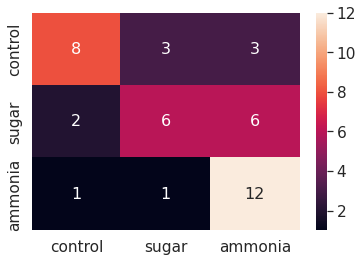

In [14]:
conf_matrix(
    model_path,
    os.path.join(path, classes[0] + '/train/'),
    os.path.join(path, classes[1] + '/train/'),
    os.path.join(path, classes[2] + '/train/') if n_classes == 3 else None,
    classes
)

Print confusion matrix for the val set

1/1 [==============================] - 0s 143ms/step


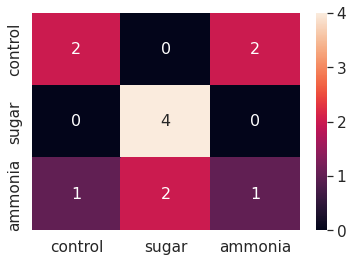

In [17]:
conf_matrix(
    model_path,
    os.path.join(path, classes[0] + '/val/'),
    os.path.join(path, classes[1] + '/val/'),
    os.path.join(path, classes[2] + '/val/') if n_classes == 3 else None,
    classes
)

Print confusion matrix for the test set

1/1 [==============================] - 0s 294ms/step


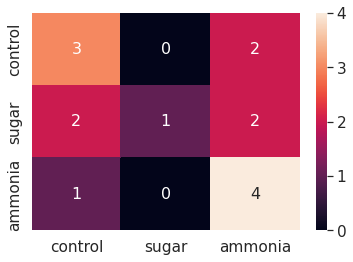

In [18]:
conf_matrix(
    model_path,
    os.path.join(path, classes[0] + '/test/'),
    os.path.join(path, classes[1] + '/test/'),
    os.path.join(path, classes[2] + '/test/') if n_classes == 3 else None,
    classes
)